In [4]:
import numpy as np
%matplotlib ipympl
from src import src
from PIL import Image
import matplotlib.pyplot as plt
import cv2


def random_draw(n, min_value=0, max_value=100):
    return np.random.randint(min_value, max_value + 1, n)


print(random_draw(2*12,1,12))

[11 12 11  7 12 12  8  3  1  1  4  3  5  7  6 11  9 12 11 11 10 12  9  3]


# BCG removal

[-5, -6.5]
[-5, -6.5]


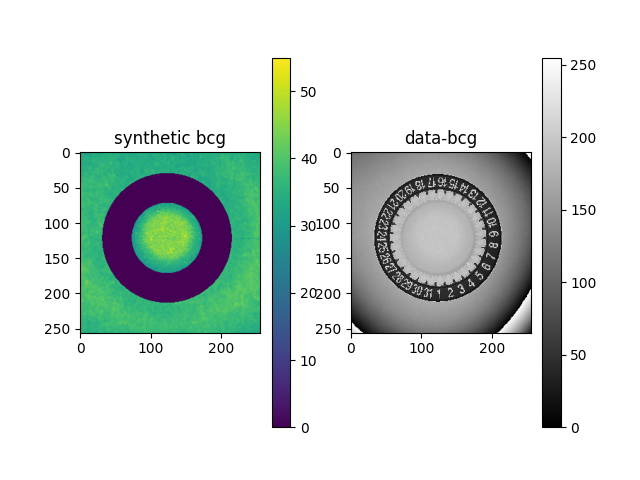

In [33]:
image = Image.open("data/30mm_BonW_5.bmp").resize((256, 256)) # Simplement pour accélèrer le processing durant le développement

data = np.asarray(image)[:,:,1] # BW => R=G=B
height, width = data.shape

mask = src.build_mask(height, width, 92, [-5,-6.5])    # Construit un masque(disque) de pour ne pas utiliser certaines données
mask += ~src.build_mask(height, width, 50, [-5,-6.5]) # Construit un !masque(disque) de pour ne !pas utiliser certaines données

x = np.linspace(-1,1,width)
y = np.linspace(-1,1,height)
grid_x, grid_y = np.meshgrid(x, y)
synt_bcg, trash = src.polynomial_mask(data, mask, [grid_x, grid_y], order=5)

data_bcg = data - synt_bcg # Ideal, the bcg values are cole to 0 comaratively to the disk

plt.close(2)
plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(data*mask)
plt.colorbar()
plt.title("synthetic bcg")
plt.subplot(1,2,2)
plt.imshow(data-synt_bcg.astype(np.uint8),cmap='gray')
# plt.imshow(data)
plt.colorbar()
plt.title("data-bcg")
plt.show()



# Distortion correction

In [ ]:
imagepath = r"measurments/"

import cv2
import numpy as np
import glob
import numpy as np
import discorpy.util.utility as utils
import discorpy.losa.loadersaver as losa
import discorpy.prep.preprocessing as prep
import discorpy.proc.processing as proc
import discorpy.post.postprocessing as post

In [ ]:
# Initial parameters
file_path = "measurments/dot.jpg"
output_base = "outputs"
num_coef = 5  # Number of polynomial coefficients
mat0 = losa.load_image(file_path) # Load image
(height, width) = mat0.shape

mat1 = prep.binarization(mat0)
# Calculate the median dot size and distance between them.
(dot_size, dot_dist) = prep.calc_size_distance(mat1)
# Remove non-dot objects
mat1 = prep.select_dots_based_size(mat1, dot_size)
# Remove non-elliptical objects
mat1 = prep.select_dots_based_ratio(mat1)
losa.save_image(output_base + "/segmented_dots.jpg", mat1) # Save image for checking
# Calculate the slopes of horizontal lines and vertical lines.
hor_slope = prep.calc_hor_slope(mat1)
ver_slope = prep.calc_ver_slope(mat1)
print("Horizontal slope: {0}. Vertical slope {1}".format(hor_slope, ver_slope))

# Group points to horizontal lines
list_hor_lines = prep.group_dots_hor_lines(mat1, hor_slope, dot_dist)
list_ver_lines = prep.group_dots_ver_lines(mat1, ver_slope, dot_dist)
list_hor_lines = prep.remove_residual_dots_hor(list_hor_lines, hor_slope)
list_ver_lines = prep.remove_residual_dots_ver(list_ver_lines, ver_slope)
# Save output for checking
losa.save_plot_image(output_base + "/horizontal_lines.png", list_hor_lines, height, width)
losa.save_plot_image(output_base + "/vertical_lines.png", list_ver_lines, height, width)


list_hor_data = post.calc_residual_hor(list_hor_lines, 0.0, 0.0)
list_ver_data = post.calc_residual_ver(list_ver_lines, 0.0, 0.0)
losa.save_residual_plot(output_base + "/hor_residual_before_correction.png",
                      list_hor_data, height, width)
losa.save_residual_plot(output_base + "/ver_residual_before_correction.png",
                      list_ver_data, height, width)

# Calculate the center of distortion
(xcenter, ycenter) = proc.find_cod_coarse(list_hor_lines, list_ver_lines)
# Calculate coefficients of the correction model
list_fact = proc.calc_coef_backward(list_hor_lines, list_ver_lines,
                                    xcenter, ycenter, num_coef)
# Save the results for later use.
losa.save_metadata_txt(output_base + "/coefficients_radial_distortion.txt",
                     xcenter, ycenter, list_fact)
print("X-center: {0}. Y-center: {1}".format(xcenter, ycenter))
print("Coefficients: {0}".format(list_fact))

# Calculate coefficients of the correction model
list_fact = proc.calc_coef_forward(list_hor_lines, list_ver_lines,
                                    xcenter, ycenter, num_coef)

# Load coefficients from previous calculation if need to
# (xcenter, ycenter, list_fact) = losa.load_metadata_txt(
#     output_base + "/coefficients_radial_distortion.txt")



# Correct the image
mat1 = losa.load_image('measurments/dot1.jpg') # Load image
corrected_mat = post.unwarp_image_backward(mat1.astype(np.uint8), xcenter, ycenter, list_fact)
losa.save_image(output_base + "/corrected_image.png", corrected_mat)
losa.save_image(output_base + "/difference.png", corrected_mat - mat1)

# Color measurement

1. Color picker
2. Threshold
3. Find disc
4. Compute CoG and compare to disk center

## Color picker

In [74]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk 

def pick_color_from_image():
    zoom = 1.0
    selected_rgb = [None]  

    def load_image():
        path = filedialog.askopenfilename(filetypes=[("Images", "*.png *.jpg *.bmp")])
        if path:
            nonlocal img, zoom
            img = Image.open(path).convert("RGB")
            fit_to_window()

    def fit_to_window():
        nonlocal zoom, tk_img
        if img:
            w, h = img.width, img.height
            cw, ch = canvas.winfo_width(), canvas.winfo_height()
            zoom = min(cw/w, ch/h)
            update_image()

    def update_image():
        nonlocal tk_img
        resized = img.resize((int(img.width*zoom), int(img.height*zoom)), Image.LANCZOS)
        tk_img = ImageTk.PhotoImage(resized)
        canvas.delete("IMG")
        canvas.create_image(0, 0, anchor=tk.NW, image=tk_img, tags="IMG")

    def get_color(event):
        x, y = int(event.x / zoom), int(event.y / zoom)
        if 0 <= x < img.width and 0 <= y < img.height:
            selected_rgb[0] = img.getpixel((x, y))
            rgb = selected_rgb[0]
            color_label.config(text=f"RGB: {rgb} | HEX: #{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}")

    def on_resize(event):
        fit_to_window()

    def on_close():
        root.destroy()

    root = tk.Tk()
    root.title("Simple Color Picker")
    root.protocol("WM_DELETE_WINDOW", on_close)

    canvas = tk.Canvas(root, bg="gray")
    canvas.pack(fill=tk.BOTH, expand=True)
    canvas.bind("<Button-1>", get_color)
    canvas.bind("<Configure>", on_resize)

    btn = tk.Button(root, text="Load Image", command=load_image)
    btn.pack(pady=5)

    color_label = tk.Label(root, text="Click on the image", bg="white")
    color_label.pack(pady=5)

    img = None
    tk_img = None

    root.mainloop()
    return selected_rgb[0]  # Return selected RGB after GUI is closed

color = pick_color_from_image()
print("Color:", color)

Color: (30, 30, 30)


## Threshold

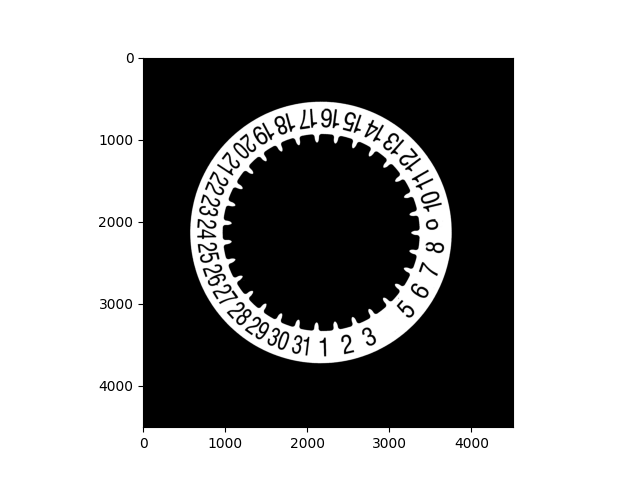

In [5]:


image = cv2.imread("data/30mm_BonW_NC_4.bmp")[:,:,0]

# lowerThresh = color[0]-10
# higherThresh = color[0]-10
ret,thresh = cv2.threshold(image,100,255,cv2.THRESH_BINARY)

plt.close(0)
plt.figure(0)
plt.imshow(thresh,cmap='gray')
plt.show()


## Find disk

circles !:  1591


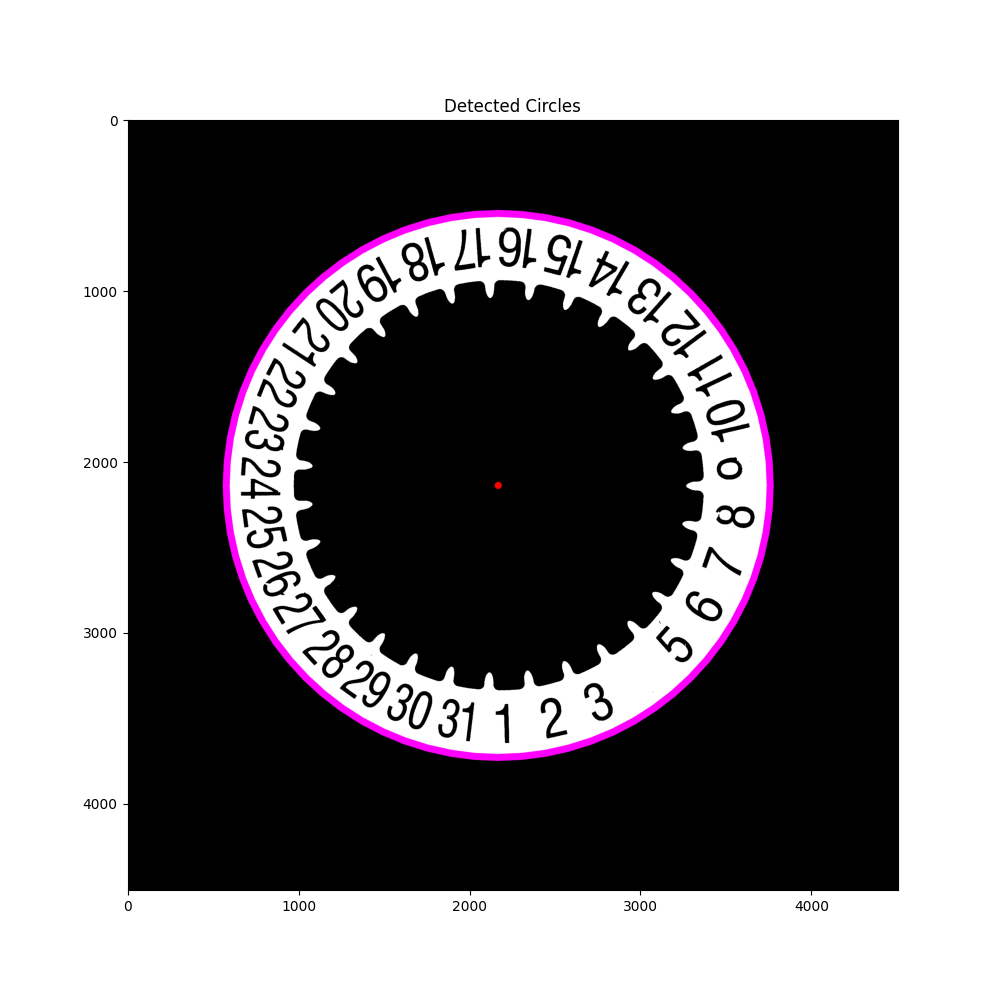

array([[[2165, 2137, 1591]]], dtype=uint16)

In [7]:
gray = thresh
#
blurred = cv2.GaussianBlur(gray, (9, 9), 2) # improves detection


circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=100, param2=30, minRadius=1570, maxRadius=1610)


output_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
if circles is not None:
    circles = np.uint16(np.around(circles))
    print("circles !: ",circles[0,0,2])
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(output_rgb, center, 1, (255, 0, 0), 40)
        # circle outline
        radius = i[2]
        cv2.circle(output_rgb, center, radius, (255, 0, 255), 40)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(output_rgb)
plt.title("Detected Circles")
plt.show()

circles


## Compute CoG and compare to disk center

33.39473954902368 20.87762520563773


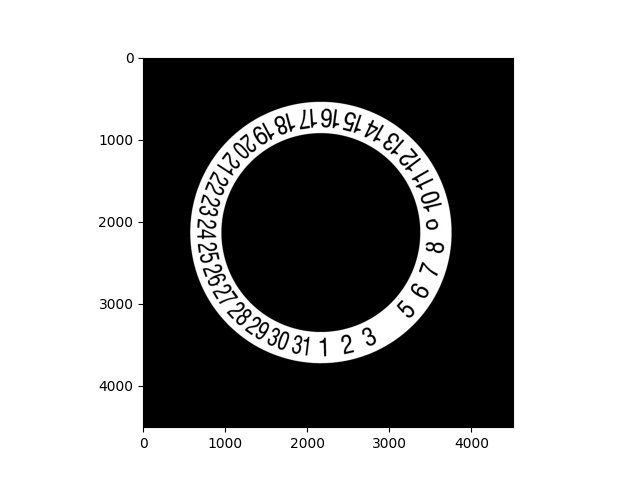

In [ ]:
raddi =[circles[0,0,2], 1210]    # [outer, inner]

image = thresh
[widht, height] = image.shape

center = [circles[0,0,0]-widht/2,circles[0,0,1]-height/2]      # [Delta x, Delta y]

x = np.linspace(-widht/2-center[0],widht/2-center[0],num=widht).astype(np.int64)
y = np.linspace(-height/2-center[1],height/2-center[1],num=height).astype(np.int64)

[X, Y] = np.meshgrid(x,y)
R = np.sqrt(X**2 + Y**2)

mask = R < raddi[0] 
mask &= R > raddi[1]

XI = X*image
YI = Y*image

# Xr = np.zeros_like(image)
xCoG = XI[mask].sum()/image[mask].sum()
yCoG = YI[mask].sum()/image[mask].sum()

print(xCoG,yCoG)

plt.close(0)
plt.figure(0)
plt.imshow(mask*image,cmap='gray')
plt.show()